Stratified Sampling Data Processing Demonstration Notebook
===========================================================

This document provides the detailed steps in the stratified sampling workflow in Python. The post-stratification weight calculation example can be found at the last section of the notebook.

<div class="alert alert-block alert-info">
<b>Tip:</b> You will find tips like this example box which provide information on other consideration during the process.
</div>

# Step 0: Import libraries and load data

In [10]:
# pandas is the main library used in this demonstration. 
import pandas as pd

# matplotlib and seaborn are used for data visualization.
import matplotlib.pyplot as plt
import seaborn as sns

# Other libraries where it is needed (import in the formula stage)
#import scipy.stats as stats

In [11]:
# The synthetic student population data is generated by another script. You can see the script in the Data Files folder.
data_folder = '~/Documents/pyladies2025-presentation/Data Files/'
population_data = pd.read_csv(data_folder + "synthetic_students.csv")

# View data structure and values
population_data.head()

,StudentID,Gender,Age,Race,Ethnicity,StudentType,OverallGPA
0,SID000001,Male,18,White,Hispanic or Latino,Freshman,4.00
1,SID000002,Female,40,Two or more races,Hispanic or Latino,Continuing Education,0.00
2,SID000003,Female,19,White,Not Hispanic or Latino,Junior,3.23
3,SID000004,Male,20,White,Not Hispanic or Latino,Senior,3.42
4,SID000005,Female,33,Black or African American,Not Hispanic or Latino,Continuing Education,0.00


# Step 1: Identifiy the strata and its proportions in the population data

This step provides a quick overview of each categorical variable and numerical variable in the population dataset. The goal is to take a quick glance of each variable, see the levels within each variable, and how much does each level represent in the overall dataset.

## Categorical variables : Gender, Race, Ethnicity, and Student Type

The four categorical variable's distribution can be assessed by checking the proportion of each level in each and `value_counts()` is used to to see the distributions of each level by each variable.

In [12]:
# Review each variable's proportions in the dataset and print the results

# Review Gender proportions
print(population_data['Gender'].value_counts(normalize=True).round(2))
print()  # Blank line for better readability
# Review Race proportions
print(population_data['Race'].value_counts(normalize=True).round(2))
print()  
# Review Ethnicity proportions
print(population_data['Ethnicity'].value_counts(normalize=True).round(2))
print()  
# Review Student Type proportions
print(population_data['StudentType'].value_counts(normalize=True).round(2))

Gender
Female     0.57
Male       0.42
Unknown    0.01
Name: proportion, dtype: float64

Race
White                                        0.55
Black or African American                    0.19
Asian                                        0.10
Two or more races                            0.07
Native Hawaiian or Other Pacific Islander    0.03
Unknown                                      0.03
American Indian or Alaska Native             0.03
Name: proportion, dtype: float64

Ethnicity
Not Hispanic or Latino    0.75
Hispanic or Latino        0.25
Name: proportion, dtype: float64

StudentType
Freshman                0.29
Senior                  0.23
Sophomore               0.19
Junior                  0.18
Continuing Education    0.10
Name: proportion, dtype: float64


## Numerical variables : Age and Overall GPA

Age and Overall GPA are numerical variables in the dataset and their distributions is evaluated by descriptive statistics.

In [13]:
# View summary statistics for numerical variables and print the results
# Overall GPA and Age
print(population_data['OverallGPA'].describe().round(2))
print()
print(population_data['Age'].describe().round(2))

count    25000.00
mean         2.81
std          1.02
min          0.00
25%          2.68
50%          3.12
75%          3.39
max          4.00
Name: OverallGPA, dtype: float64

count    25000.00
mean        19.63
std          2.82
min         17.00
25%         18.00
50%         19.00
75%         20.00
max         44.00
Name: Age, dtype: float64


## Group Comparison: Gender and Age

Group Comparison is checking a categorical variables by the numerical variables to see if the distributions differ significantly. This is helpful in stratified sampling to evaluate how each stratum is represented in the population. When each variable or a combination of variables will be a part of the strata and their distributions need to be known.

In [14]:
# This example uses Gender as the categorical variable and Age as the numerical variables for group comparison.

# Take a level in Gender, e.g., Male and see the range of Age and the average Age for Male students
population_data_male = population_data[population_data['Gender'] == 'Male']
print("Male Age Summary:")
print(population_data_male['Age'].describe().round(2))

Male Age Summary:
count    10535.00
mean        19.61
std          2.76
min         17.00
25%         18.00
50%         19.00
75%         20.00
max         44.00
Name: Age, dtype: float64


In [15]:
# Take the Female level in Gender and see the range of Age and the average Age for Female students
population_data_female = population_data[population_data['Gender'] == 'Female']
print("Female Age Summary:")
print(population_data_female['Age'].describe().round(2))

Female Age Summary:
count    14230.00
mean        19.64
std          2.87
min         17.00
25%         18.00
50%         19.00
75%         20.00
max         43.00
Name: Age, dtype: float64


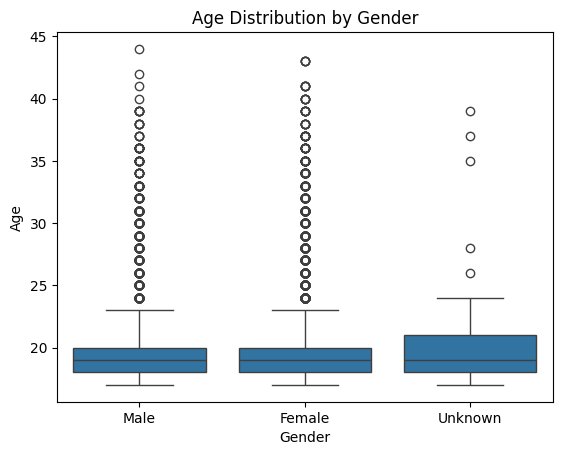

In [16]:
# Since the Gender variable has three levels, we can make a side by side box plots to compare the Age distribution across Gender levels

# Boxplot of Age distribution by Gender
sns.boxplot(data=population_data, x='Gender', y='Age')
plt.title('Age Distribution by Gender')
plt.show() 

Note. Because of the outliers in Age variable, you can see the effect of outliers in the box plot. The box plot shows the median, interquartile range, and potential outliers in the Age variable distribution.

<div class="alert alert-block alert-info">
<b>Tip:</b> The descriptive statistics such as mean, median, and standard deviation can provide insights into the distribution of numerical variables within each category. In this example, the age distribution is fairly similar between male and female students.
</div>

Note. You can run other group comparison if you want to explore other relationship or conduct data clearning. For demonstration purposes, this synthtetic data is already clean, so no additional cleaning steps are necessary.

# Step 2: Determine the sample size and proportions for each subgroup

This step involves calculating the required sample size from the overall population. Then, the sample size will be allocated to each stratum based on their proportions in the population.

## 2.1 Cochran's Sample Size Formula and the Finite Population Correction

Cochran's Sample Size Formula is used to calculate the initial sample size needed for the study. This is a common formula used in survey sampling to determine the sample size required to achieve a desired level of precision and confidence in the results.

In [17]:
# Cochran's Sample Size Formula and the Finite Population Correction

# Using the Scipy library stats module to get the Z value
import scipy.stats as stats

def cochran_sample_size(Z, p, e, N):
    """
    Calculate the required sample size using Cochran's formula, adjusted for a finite population.

    Parameters:
        Z (float): Z-value (e.g., 1.96 for 95% confidence level)
        Z = stats.norm.ppf(0.975)   # Z-score for the upper tail of a two-tailed 95% confidence interval (1.96 for 95% confidence)
        e (float): Margin of error (e.g., 0.05 for 5%)
        N (int): Population size

    Returns:
        int: Adjusted sample size for the finite population
    """
    n0 = (Z**2 * p * (1 - p)) / (e**2)
    n = n0 / (1 + ((n0 - 1) / N))
    return int(n)

# Parameters
Z = stats.norm.ppf(0.975)   # Calculate the critical z-value for a 95% confidence level in a standard normal distribution
p = 0.5                     # Estimated proportion (use 0.5 for maximum variability, sort of like worst-case scenario)
e = 0.05                    # Margin of error (precision level, more precision requires larger sample size)
N = 25000                   # Finite population size (in this example, student population size)

# Calculate sample size

# Calculate n0 and adjusted sample size for finite population 
n0 = (Z**2 * p * (1 - p)) / (e**2)
sample_size = n0 / (1 + ((n0 - 1) / N))

# Print results
print("Cochran's Sample Size Calculation:")
print(f"Ideal sample size (n0) for 95% confidence level: {round(n0)}")
print(f"Adjusted sample size of finite population for 95% confidence level: {int(sample_size)}")

Cochran's Sample Size Calculation:
Ideal sample size (n0) for 95% confidence level: 384
Adjusted sample size of finite population for 95% confidence level: 378


## 2.2 Re-code numerical variables into categorical values for stratification

In the previous step, we have seen the distributions of numerical variables such as Age and Overall GPA. To include these numerical variables in the stratification process, we need to convert them into categorical variables by creating bins or ranges. The reason is because stratified sampling works best with categorical variables where each category or level represents a distinct subgroup within the population. Age has such a wide range of values that it is better to group them into categories for stratification.

### 2.2.1 Re-code Age to Age Group

In [18]:
# Revisit the age distribution from previous exploration
print(population_data['Age'].describe().round(2))

count    25000.00
mean        19.63
std          2.82
min         17.00
25%         18.00
50%         19.00
75%         20.00
max         44.00
Name: Age, dtype: float64


In [19]:
# Show the number of count by each age level
age_counts = population_data['Age'].value_counts().sort_index()
# Print the first 10 age levels and their counts
print(age_counts.head(10))

Age
17    3787
18    6336
19    3820
20    5076
21    3292
22     930
23     309
24     197
25     170
26     159
Name: count, dtype: int64


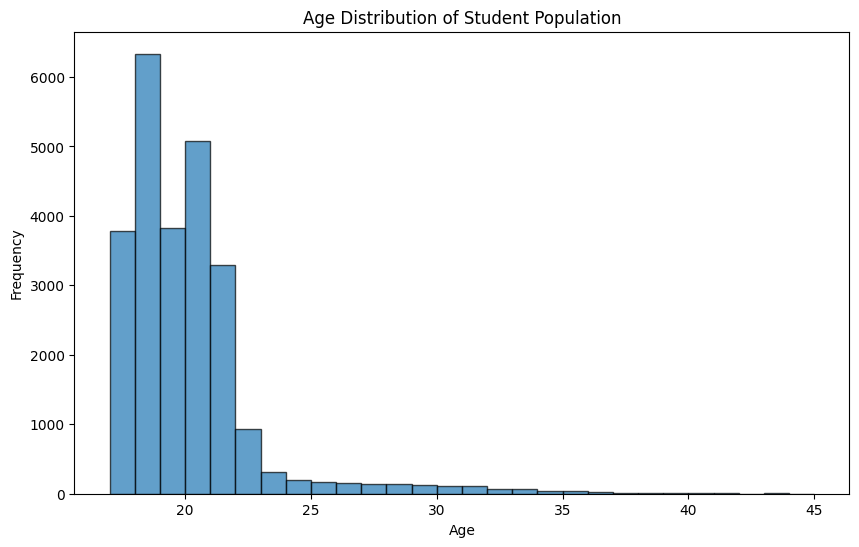

In [20]:
# Show the frequency distribution of Age variable
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(population_data['Age'], bins=range(17, 46), edgecolor='black', alpha=0.7)
plt.title('Age Distribution of Student Population')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

From the age distribution plot, we observed that the age distribution is right-skewed with a mean age of 19.63 years with a range from 18 to 44 years. I will demonstrate a simple method by using two intervals: 2-year interval and the 10-year intervals for older age groups (due to fewer data points). Then, I will demonstrate a more balanced approach using grouping that is more meaningful for the study's context in Example 2.

**Example 1: By increments of 2 or 10 years**

In [21]:
# Binding age groups by increments of 2 years for younger ages and 10 years for older ages
population_data['Age_Group_1'] = pd.cut(population_data['Age'], 
                                       bins=[17, 19, 21, 23, 25, 27, 29, 31, 41, 50],
                                       labels=['17-18', '19-20', '21-22', '23-24', '25-26', '27-28', '29-30', '31-40', '41-50'], right=False)
# View the first 3 records to confirm the new Age_Group variable added by the pd.cut function
population_data[['Age', 'Age_Group_1']].head(3)

,Age,Age_Group_1
0,18,17-18
1,40,31-40
2,19,19-20


In [22]:
# View the distribution after recoding for both counts and proportions
# Make a list of two outputs: counts and proportions
# To view counts
age_1_group_counts = population_data['Age_Group_1'].value_counts().sort_index()
# To view proportions
age_1_group_proportions = population_data['Age_Group_1'].value_counts(normalize=True).sort_index().round(3)
age_1_group_counts, age_1_group_proportions

(Age_Group_1
 17-18    10123
 19-20     8896
 21-22     4222
 23-24      506
 25-26      329
 27-28      277
 29-30      235
 31-40      400
 41-50       12
 Name: count, dtype: int64,
 Age_Group_1
 17-18    0.405
 19-20    0.356
 21-22    0.169
 23-24    0.020
 25-26    0.013
 27-28    0.011
 29-30    0.009
 31-40    0.016
 41-50    0.000
 Name: proportion, dtype: float64)

**Example 2: By meaningful groups**

Rationale: We know that in general most undergraduates will finish college between the age of 21-23, and graduate students will typically start at age 24 to 30. Therefore, we can group ages accordingly to this context to better reflect the population structure from this college. In this example, there is no graduate studies but is referred as Continuing Education in the Student Type variable.

In [23]:
# Re-code Age by meaningful groups, such as typical college age, graduate age, and then beyond.
# We will keep the first three groups like the previous example, but then group all older ages into one group, as 31 and above, ' 31+

population_data['Age_Group_2'] = pd.cut(population_data['Age'], 
                                       bins=[17, 19, 21, 23, 25, 31, 44],
                                       labels=['17-18', '19-20', '21-22', '23-25', '26-30', '31+'],
                                   right=False)
# View the last 5 records to confirm the new Age_Group variable is added by the pd.cut function
population_data[['Age', 'Age_Group_2']].tail(5)

,Age,Age_Group_2
24995,21,21-22
24996,23,23-25
24997,20,19-20
24998,19,19-20
24999,19,19-20


In [24]:
# View the distribution after recoding for both counts and proportions
# To view counts
age_2_group_counts = population_data['Age_Group_2'].value_counts().sort_index()
# To view proportions
age_2_group_proportions = population_data['Age_Group_2'].value_counts(normalize=True).sort_index().round(3)
age_2_group_counts, age_2_group_proportions

(Age_Group_2
 17-18    10123
 19-20     8896
 21-22     4222
 23-25      506
 26-30      841
 31+        411
 Name: count, dtype: int64,
 Age_Group_2
 17-18    0.405
 19-20    0.356
 21-22    0.169
 23-25    0.020
 26-30    0.034
 31+      0.016
 Name: proportion, dtype: float64)

<div class="alert alert-block alert-info">
<b>Tip:</b> Based on the research objective and the population characteristics, you can choose different ways to group numerical variables. The key is to ensure that the groups are meaningful and relevant to the study context.
</div>

## Step 3: Forming strata and selecting samples by proportions

First, I will demonstrate a quick example to help illustrate the decision making process of strata formation and sample selection.

For example: How many sample cases do we need if we are to select a stratified random sample based on Age Groups?

In [25]:
# Let's say we are to use Age_Group_2 for stratified random sampling

# The cases we need will be the proportions of each age group multiplied by the total sample size calculated earlier, the counts and proportions are commented out for clarity.
# age_group_2_counts = population_data['Age_Group_2'].value_counts().sort_index()
# age_group_2_proportions = age_group_2_counts / len(population_data)

# Ensure sample size is an integer since we are talking about a person, and this value comes from previous calculation
sample_size_ex = int(sample_size)  

# Then calculate the sample sizes needed for each age group and round to the nearest integer as well
age_group_sample_sizes = (age_2_group_proportions * sample_size_ex).round().astype(int)

# The final sample count may be more or less than the calculated sample size due to rounding.
print("Sample sizes needed for each Age Group:", age_group_sample_sizes)

Sample sizes needed for each Age Group: Age_Group_2
17-18    153
19-20    135
21-22     64
23-25      8
26-30     13
31+        6
Name: proportion, dtype: int64


Note. This is only a demonstration of how to know the number of cases you need from each level within a variable. The final stratified sample will be based on the characteristics of all stratification variables combined, and not individually.

### 3.1 More data cleaning and preparation before random sampling

#### Gender

The first variable, `Gender` has an unknown category, and we have to think about if this information is important for our analysis. Let say we want to implement some programs or initiatve after the study, but when a Gender is unknown, we may not be able to design specific services for this group without this identification. Therefore, the decision making process becomes more complex and needed careful consideration.

For this demonstration, I will drop the unknown category to simplify the process because we want to focus on the methodology of stratified sampling.

In [26]:
# We will make a copy of the required variables and form a new DataFrame
sample_selection_data = population_data[['StudentID', 'Gender', 'Race', 'Age_Group_2']].copy()
sample_selection_data.head()

,StudentID,Gender,Race,Age_Group_2
0,SID000001,Male,White,17-18
1,SID000002,Female,Two or more races,31+
2,SID000003,Female,White,19-20
3,SID000004,Male,White,19-20
4,SID000005,Female,Black or African American,31+


In [27]:
# For Gender, we would like to remove the 'Unknown' category and make a new column for the modified values.
sample_selection_data['Gender_m'] = sample_selection_data['Gender'].replace({'Unknown': None})

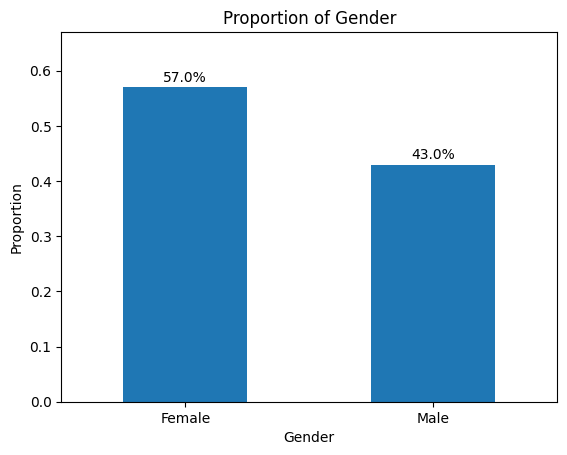

In [28]:
# Create a distribution chart for each of the three variables after recoding

# Proportion of Gender in the Sample Selection Data and add the proportion on top of each bar
gender_proportions = sample_selection_data['Gender_m'].value_counts(normalize=True).round(2)
gender_proportions.plot(kind='bar', title='Proportion of Gender')
plt.xticks(rotation=0)

# Round to 2 decimal places and convert to percentage
for i, v in enumerate(gender_proportions):
    plt.text(i, v + 0.01, str(round(v * 100, 2)) + '%', ha='center')

# Adjust the y-axis label to give more space for the percentage text
plt.ylim(0, max(gender_proportions) + 0.1)

plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.show()

#### Race

The second variable that we are using for stratification is `Race`. Upon reviewing the race distribution, we found that some categories may be too small by proportion to produce reliable results during sampling. For example, American Indian or Alaska Native and Native Hawaiian or Other Pacific Islander by proportion are quite small. To ensure that our stratified sampling is effective and that each stratum has a sufficient number of cases to survey or for analysis, we will combine them into a single group called "Other". Again, the decision to combine categories should be made based on the research objectives and the importance of these categories in the analysis.

In [29]:
# Show the proportion of each race category from the population data
print(population_data['Race'].value_counts(normalize=True))

Race
White                                        0.55204
Black or African American                    0.18620
Asian                                        0.10100
Two or more races                            0.07016
Native Hawaiian or Other Pacific Islander    0.03088
Unknown                                      0.03068
American Indian or Alaska Native             0.02904
Name: proportion, dtype: float64


In [30]:
# A quick example of how many cases will be in each race category if we are to use all the original race levels by itself
# create the race proportions variables
race_proportions = population_data['Race'].value_counts(normalize=True).sort_index()

# Then calculate the sample sizes needed for each race group and round to the nearest integer as well
race_group_sample_sizes = (race_proportions * sample_size_ex).round().astype(int)

# The final sample count may be more or less than the calculated sample size due to rounding.
print("Sample sizes needed for each Race Group:", race_group_sample_sizes)

Sample sizes needed for each Race Group: Race
American Indian or Alaska Native              11
Asian                                         38
Black or African American                     70
Native Hawaiian or Other Pacific Islander     12
Two or more races                             27
Unknown                                       12
White                                        209
Name: proportion, dtype: int64


Combine Race and Gender by proportion to see the sample sizes needed for each combined group if we are to use both variables for stratification.

In [31]:
# Combine Race and Gender by proportion to see the sample sizes needed for each combined group if we are to use both variables for stratification.
combined_counts = sample_selection_data.groupby(['Race', 'Gender_m']).size()
combined_proportions = combined_counts / len(sample_selection_data)
combined_sample_sizes = (combined_proportions * sample_size_ex).round().astype(int)
print("Sample sizes needed for each combined Race and Gender Group:", combined_sample_sizes)

Sample sizes needed for each combined Race and Gender Group: Race                                       Gender_m
American Indian or Alaska Native           Female        6
                                           Male          5
Asian                                      Female       21
                                           Male         16
Black or African American                  Female       40
                                           Male         30
Native Hawaiian or Other Pacific Islander  Female        6
                                           Male          5
Two or more races                          Female       15
                                           Male         11
Unknown                                    Female        7
                                           Male          5
White                                      Female      119
                                           Male         88
dtype: int64


As you can see, once the two variables are combined, the number of strata increases significantly. This means that we will need to ensure that our sample size is large enough to accommodate all the strata and still maintain the desired level of precision in our estimates. We can either reduce the levels within each variable or increase the overall sample size to ensure that each stratum has enough representation in the final sample. In this demonstration, we will do both steps, in which we will reduce the levels within each variable and also increase the overall sample size to ensure that each stratum has enough representation in the final sample.

In [32]:
# For Race, we can combine 'American Indian or Alaska Native' with the 'Native Hawaiian or Other Pacific Islander', into a single 'Other' category.
sample_selection_data['Race_m'] = sample_selection_data['Race'].replace({'American Indian or Alaska Native': 'Other',
                                                          'Native Hawaiian or Other Pacific Islander': 'Other'})

# Remove Unknown from Race, Race_m is the modified column
sample_selection_data['Race_m'] = sample_selection_data['Race_m'].replace({'Unknown': None})
sample_selection_data['Race_m'].value_counts(normalize=True).round(5)

# Note. Because some cases are removed due to unknown categories and therefore the denominator changes as well.
# The proportions shown here are based on the modified dataset after removing unknowns and its different to the original population proportions.

Race_m
White                        0.56951
Black or African American    0.19209
Asian                        0.10420
Two or more races            0.07238
Other                        0.06182
Name: proportion, dtype: float64

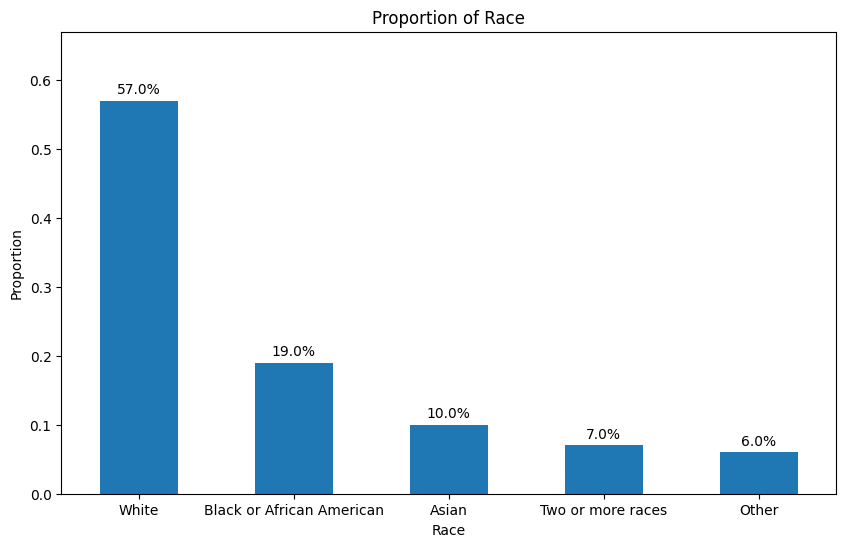

In [33]:
# Proportion of Race in the Sample Selection Data
race_proportions = sample_selection_data['Race_m'].value_counts(normalize=True).round(2)

# Plot the proportions of Race
plt.figure(figsize=(10, 6))
race_proportions.plot(kind='bar', title='Proportion of Race')
plt.xticks(rotation=0)

# Round to 2 decimal places and convert to percentage
for i, v in enumerate(race_proportions):
    plt.text(i, v + 0.01, str(round(v * 100, 2)) + '%', ha='center')

# Adjust the y-axis label to give more space for the percentage text
plt.ylim(0, max(gender_proportions) + 0.1)

plt.xlabel('Race')
plt.ylabel('Proportion')
plt.show()

#### Review proportions after cleaning

Age Group is already re-coded in the previous step, so we can directly check the proportions after cleaning the other two variables.

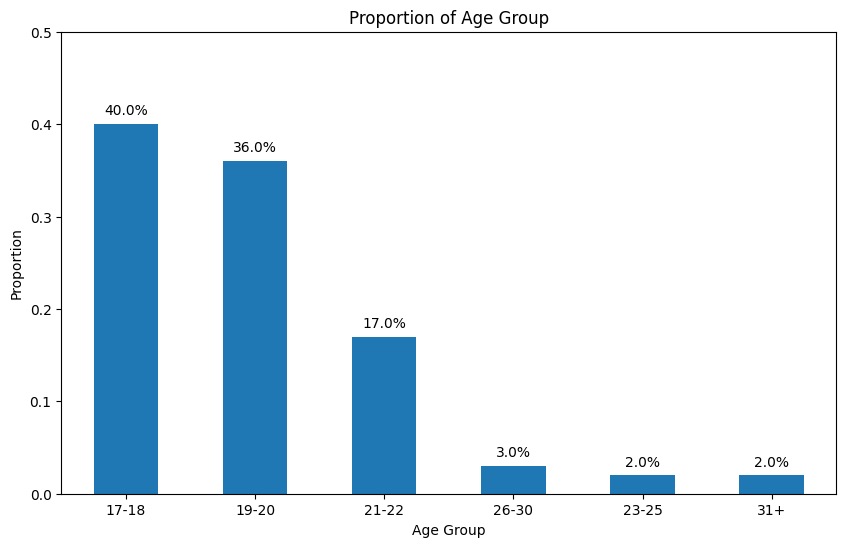

In [34]:
# Proportion of Age Group in the Sample Selection Data
age_proportions = sample_selection_data['Age_Group_2'].value_counts(normalize=True).round(2)

# Plot the proportions of Age Group
plt.figure(figsize=(10, 6))
age_proportions.plot(kind='bar', title='Proportion of Age Group')
plt.xticks(rotation=0)

# Round to 2 decimal places and convert to percentage
for i, v in enumerate(age_proportions):
    plt.text(i, v + 0.01, str(round(v * 100, 2)) + '%', ha='center')

# Adjust the y-axis label to give more space for the percentage text
plt.ylim(0, max(age_proportions) + 0.1)

plt.xlabel('Age Group')
plt.ylabel('Proportion')
plt.show()

In [35]:
# Proportion of Gender in the Sample Selection Data
print(sample_selection_data['Gender_m'].value_counts(normalize=True).round(2))
print()
# Proportion of Race in the Sample Selection Data
print(sample_selection_data['Race_m'].value_counts(normalize=True).round(2))
print()
# Proportion of Age Group in the Sample Selection Data
print(sample_selection_data['Age_Group_2'].value_counts(normalize=True).round(2))

Gender_m
Female    0.57
Male      0.43
Name: proportion, dtype: float64

Race_m
White                        0.57
Black or African American    0.19
Asian                        0.10
Two or more races            0.07
Other                        0.06
Name: proportion, dtype: float64

Age_Group_2
17-18    0.40
19-20    0.36
21-22    0.17
26-30    0.03
23-25    0.02
31+      0.02
Name: proportion, dtype: float64


These proportions will be used to guide the random sampling process to ensure that the final sample reflects the population structure accurately. They should also matched to the previous proportions calculated in this part of the procedure.

#### Other information of the Sample Selection dataframe

In [36]:
# What is the size of the sample selection data? 
print(f"Size of the sample selection data: {len(sample_selection_data)}")

# The dataframe didn't change, but now the variables are cleaned and ready for stratified sampling. 
# You will see missing values in the modified columns where we removed 'Unknown' categories.

# How much missing values are in each modified column?
print("The missing values in each modified column:")
print(sample_selection_data[['Gender_m', 'Race_m']].isnull().sum())
# What is the percentage of missing values in each modified column?
print("The percentage of missing values in each modified column:")
print((sample_selection_data[['Gender_m', 'Race_m']].isnull().mean() * 100).round(2))

# We have no other means to infer the missing values, so we will keep them as is for the stratified sampling process.

Size of the sample selection data: 25000
The missing values in each modified column:
Gender_m    235
Race_m      767
dtype: int64
The percentage of missing values in each modified column:
Gender_m    0.94
Race_m      3.07
dtype: float64


In research, transparency is key. When reporting the process of your work, it is essential to provide information about how the stratified sampling process was conducted. This includes: any data cleaning steps, the sample size calculation, the stratification variables used, and the proportions of each stratum in both the population and the sample.

Clarify any adjustments made to the data, such as combining categories or handling unknown or missing values. In this example, the 'Unknown' labels will always be there because student demographic information are often self-reported data. Therefore, it is important to explain how these cases were treated in the sampling process and the potential implications for the study's findings. You may keep the Unknown in the sampling process, but may discover that once you are forming the strata, there may not be any cases in the Unknown category selected for the sample.

You can also consider another technique called sensitivity analysis to evaluate how the assumptions made during the stratification process may impact the results. You can run the analyses with and without certain categories (e.g., including vs. excluding 'Unknown') and compare outcomes to assess robustness. However, we will not demonstrate this technique in this notebook.

### 3.2 Calculate proportions of the strata in the sample selection data

Setup a dataframe with the combination of the three variables of each strata and then calculate their counts and proportions.

This will be called stratum_set_1 dataframe as an example.

In [37]:
# Determine the combined proportions of the strata in the sample selection data with the modified variables
stratum_set_1 = sample_selection_data.groupby(['Gender_m', 'Race_m', 'Age_Group_2'], observed=True).size().reset_index(name='Count')
stratum_set_1['Proportion'] = stratum_set_1['Count'] / stratum_set_1['Count'].sum()

# View the first 10 records of the stratum_set_1 dataframe
stratum_set_1.head(10)

,Gender_m,Race_m,Age_Group_2,Count,Proportion
0,Female,Asian,17-18,582,0.024247
1,Female,Asian,19-20,501,0.020872
2,Female,Asian,21-22,229,0.009540
3,Female,Asian,23-25,21,0.000875
4,Female,Asian,26-30,54,0.002250
5,Female,Asian,31+,27,0.001125
6,Female,Black or African American,17-18,1066,0.044411
7,Female,Black or African American,19-20,912,0.037995
8,Female,Black or African American,21-22,462,0.019248
9,Female,Black or African American,23-25,75,0.003125


From the output, we can see that most of the small strata are associated with age groups that are older than typical college age and the race groups with smaller representation in the population. For demonstration purposes, we will continue to next steps so that you can see how samples are drawn from the strata set 1. Then, we will discuss other options. 

In [38]:
# Number of strata formed in this set 1
print(f"Number of strata formed in this set: {len(stratum_set_1)}")

Number of strata formed in this set: 60


In this attempt, we can see 60 strata and we have not conduct the selection step yet. Thus, 60 is a bit large comparing to 378 samples.
We can foresee that some strata will have very small counts and we will face problems in pulling a sample person.

### 3.3. Draw the random sample based on the strata proportions in stratum set 1

In [39]:
#  Quick view of the counts distribution of this stratum set 1 with 378 samples.
stratum_sample_1 = (stratum_set_1['Proportion'] * sample_size_ex).round().astype(int)
# Show the strata that has very small counts
small_counts_strata = stratum_sample_1[stratum_sample_1 < 3]
print("Strata with very small counts (only the first 10 records):", small_counts_strata.head(10))
# The number of strata with small counts may indicate potential issues in sampling later.

Strata with very small counts (only the first 10 records): 3     0
4     1
5     0
9     1
10    2
11    1
15    0
16    1
17    0
20    2
Name: Proportion, dtype: int64


<div class="alert alert-block alert-info">
<b>Tip:</b>

Note. This is a good time to explain the differences between stratified random sampling and a balanced sample approach, as it is often confused. 

A balanced sample would have equal representation from each stratum, regardless of their proportion in the population. In contrast, stratified random sampling aims to reflect the actual distribution of the population across strata, ensuring that each stratum is representing the proportion in the population. This approach helps to maintain the representativeness of the sample while still allowing for detailed analysis within each stratum. 

Often, this is the reality we face as some groups are less representative when compared to the overall population. There are other techniques to address this issue, such as oversampling underrepresented strata or using different sampling methods altogether. It is important to consider these factors when designing a study and interpreting the results. 

There are also post-hoc techniques to adjust for small strata during analysis, such as weighting or combining strata when the results are reported. Post-stratification weighting will be demonstrated in the last section of this notebook.
</div>

As you can see in this example, the needed sample sizes for some strata are 1 or less than 1, which is not feasible for sampling.

At this stage, any proportional adjustments can be made to ensure that no stratum has a sample size less than 1. If we do that though, we consider it "disproportionate stratified sampling" rather than a "proportionate stratified sampling" approach. Because you sort of "over-sample" some strata to ensure they have at least one sample. This can be done if your objective is to increase precision for key subgroups. 

Another method is to increase the overall sample size, for example the current sample size estimate is using 95% confidence intervals and 5% margin of error. If we tightened the margin of error to 1% or 3%, the overall sample size will increase, which may help address the small stratum sizes. However, this approach also has trade-offs, as a larger sample size may require more resources and there is no guarantee that all strata will have sufficient representation during the survey administration.

### 3.3.1 Repeat sample size calculation and estimate a larger sample size

In this section, I will demonstrate how to repeat the sample size calculation with a larger sample size by adjusting the margin of error from 5% to 3% or from 5% to 1%. There is also an example of changing 95% confidence level to 99%. These attempts will increase the overall sample size and may help address the issue of small stratum sizes. However, keep in mind that increasing the sample size will also increase the cost and time required for data collection. Therefore, it is important to balance the need for a larger sample size with the available resources and budget for the study.

#### Example 1: Reduce margin of error from 5% to 3%

In [40]:
# This time we are using a different set of parameters. The formula remains the same from Step 2.

# Parameters
Z = stats.norm.ppf(0.975)   # Calculate the critical z-value for
# a 95% confidence level in a standard normal distribution
p = 0.5                     # Estimated proportion (use 0.5 for maximum variability, sort of like worst-case scenario)
e_3 = 0.03                    # Margin of error (precision level, more precision requires larger sample size)
N = 25000                   # Finite population size (in this example, student population size)

# Calculate sample size
# Calculate n0 and adjusted sample size for finite population
n0 = (Z**2 * p * (1 - p)) / (e_3**2)
sample_size_three_moe = n0 / (1 + ((n0 - 1) / N))
# Print results
print(f"Ideal sample size (n0) for 95% confidence level with 3% margin of error: {round(n0)}")
print(f"Adjusted sample size of finite population for 95% confidence level with 3% margin of error: {int(sample_size_three_moe)}")

Ideal sample size (n0) for 95% confidence level with 3% margin of error: 1067
Adjusted sample size of finite population for 95% confidence level with 3% margin of error: 1023


#### Example 2: Reduce margin of error from 5% to 1%

In [41]:
# What if the margin of error is reduced to 1%?
# Calculate sample size
e_1 = 0.01                    # Margin of error (precision level, more precision requires larger sample size)
# Calculate n0 and adjusted sample size for finite population
n0 = (Z**2 * p * (1 - p)) / (e_1**2)
sample_size_one_moe = n0 / (1 + ((n0 - 1) / N))
# Print results
print(f"Ideal sample size (n0) for 95% confidence level with 1% margin of error: {round(n0)}")
print(f"Adjusted sample size of finite population for 95% confidence level with 1% margin of error: {int(sample_size_one_moe)}")

Ideal sample size (n0) for 95% confidence level with 1% margin of error: 9604
Adjusted sample size of finite population for 95% confidence level with 1% margin of error: 6938


#### Example 3: Increase confidence level from 95% to 99% and keep margin of error at 5%

In [42]:
# Will increasing the confidence interval to 99% help?
# Calculate sample size
Z = stats.norm.ppf(0.995)   # Calculate the critical z-value for a 99% confidence level in a standard normal distribution
p = 0.5                     # Estimated proportion (use 0.5 for maximum variability
e_5 = 0.05                    # Margin of error (precision level, more precision requires larger sample size)
N = 25000                   # Finite population size (in this example, student population size

# Calculate sample size
# Calculate n0 and adjusted sample size for finite population
n0 = (Z**2 * p * (1 - p)) / (e_5**2)
sample_size_99ci = n0 / (1 + ((n0 - 1) / N))
# Print results
print(f"Ideal sample size (n0) for 99% confidence level: {round(n0)}")
print(f"Adjusted sample size of finite population for 99% confidence level: {int(sample_size_99ci)}")

Ideal sample size (n0) for 99% confidence level: 663
Adjusted sample size of finite population for 99% confidence level: 646


<div class="alert alert-block alert-info">
<b>Tip:</b>
Based on the results from the three examples above, you can see that increasing the sample size by reducing the margin of error or increasing the confidence level can help address the issue of small stratum sizes. However, it is important to carefully consider the trade-offs between sample size, cost, and time when making decisions about the sampling design.

For this demonstration, we will proceed with the sample size calculated with 3% margin of error in the next step.
</div>

### 3.4 Draw the random sample based on the strata set 1

Since the sample size estimate with 3% margin of error is 1,067, we can see if this larger sample size can help address the small counts due to having 60 types of combined strata.

In [43]:
# Use the 3% margin of error sample size estimate to draw the stratified random sample
stratum_sizes_three_moe = (stratum_set_1['Proportion'] * int(sample_size_three_moe)).round().astype(int)

# Add the grouping variables back to the stratum sizes DataFrame for clarity
stratum_sizes_three_moe = pd.concat([stratum_set_1[['Gender_m', 'Race_m', 'Age_Group_2']], stratum_sizes_three_moe.rename('Sample_Size')], axis=1)

# Show the strata that has very small counts
small_counts_strata = stratum_sizes_three_moe[stratum_sizes_three_moe['Sample_Size'] < 5]
print("Strata with very small counts:")
print(small_counts_strata.head())

Strata with very small counts:
   Gender_m                     Race_m Age_Group_2  Sample_Size
3    Female                      Asian       23-25            1
4    Female                      Asian       26-30            2
5    Female                      Asian         31+            1
9    Female  Black or African American       23-25            3
10   Female  Black or African American       26-30            4


A quick comparison to the 99% confidence level with 5% margin of error sample size estimate.

In [44]:
# use the 99% confidence level sample size to draw the stratified random sample
stratum_sizes_99ci = (stratum_set_1['Proportion'] * int(sample_size_99ci)).round().astype(int)

# Add the grouping variables back to the stratum sizes DataFrame for clarity
stratum_sizes_99ci = pd.concat([stratum_set_1[['Gender_m', 'Race_m', 'Age_Group_2']], stratum_sizes_99ci.rename('Sample_Size')], axis=1)
# Show the strata that has very small counts
small_counts_strata = stratum_sizes_99ci[stratum_sizes_99ci['Sample_Size'] < 5]
print("Strata with very small counts:")
print(small_counts_strata.head())

Strata with very small counts:
   Gender_m                     Race_m Age_Group_2  Sample_Size
3    Female                      Asian       23-25            1
4    Female                      Asian       26-30            1
5    Female                      Asian         31+            1
9    Female  Black or African American       23-25            2
10   Female  Black or African American       26-30            3


In this iteration, it is decided to use the 3% margin of error sample size estimate and now we can proceed to drawing the random sample.

## Step 4. Apply random selection and form the completed sample dataset

### 4.1 Sample selection and final dataset formation

The code example in the presentation is provided here to demonstrate how to draw the stratified random sample based on the strata proportions and the adjusted sample size estimate with 3% margin of error.

In [45]:
# Initialize an empty list to hold sampled dataframes
sampled_groups = []

# Iterate through each stratum and perform stratified sampling
for i, row in stratum_sizes_three_moe.iterrows():
    stratum_filter = (
        (sample_selection_data['Gender_m'] == row['Gender_m']) &
        (sample_selection_data['Race_m'] == row['Race_m']) &
        (sample_selection_data['Age_Group_2'] == row['Age_Group_2'])
    )
    stratum_population = sample_selection_data[stratum_filter]
    # Use the sample size from the current row
    stratum_sample_size = int(row['Sample_Size'])

    # Ensure we don't sample from empty strata or more than available
    n = min(stratum_sample_size, len(stratum_population))
    if n > 0:
        stratum_sample = stratum_population.sample(n=n, replace=False)
        sampled_groups.append(stratum_sample)

# Combine all sampled dataframes into a single dataframe (guard against empty list)
if sampled_groups:
    sampled_dataset = pd.concat(sampled_groups).reset_index(drop=True)
else:
    sampled_dataset = pd.DataFrame(columns=sample_selection_data.columns)

# Create an alias expected by downstream cells and align column naming
sampled_data = sampled_dataset.copy()
if 'Age_Group' not in sampled_data.columns and 'Age_Group_2' in sampled_data.columns:
    sampled_data['Age_Group'] = sampled_data['Age_Group_2']

# View the first three rows of the sampled dataset
print("Sampled dataset (first 3 rows):")
print(sampled_data[['StudentID', 'Gender_m', 'Race_m', 'Age_Group']].head(3))

Sampled dataset (first 3 rows):
   StudentID Gender_m Race_m Age_Group
0  SID016702   Female  Asian     17-18
1  SID013908   Female  Asian     17-18
2  SID005806   Female  Asian     17-18


In [46]:
# Print the size of the sampled dataset
print(f"Size of the sampled dataset: {len(sampled_data)}")

Size of the sampled dataset: 1024


This roster will be the final sample dataset for survey administration. In your process, you may have to consider other methods to ensure anonymity while still being able to link responses to the sample roster for analysis purposes.

### 4.2 Last Check: Compare proportions in final sample dataset and population dataset

#### Sample dataset proportions and plots

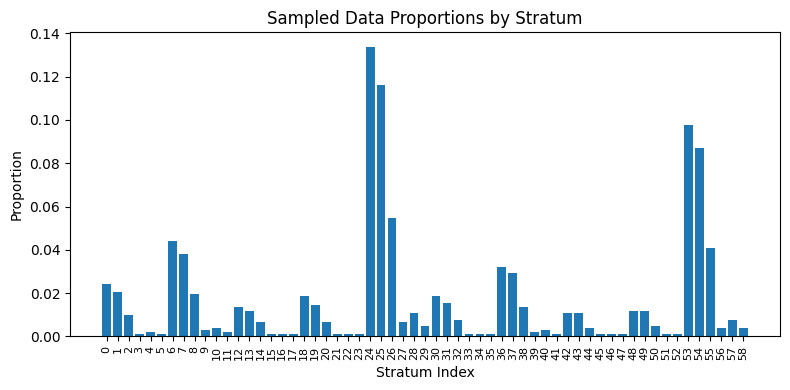

,Proportion
0,0.024
1,0.021
2,0.010
3,0.001
4,0.002


In [47]:
# Calculate the proportions in the sampled data
sample_proportions = sampled_dataset.groupby(['Gender_m', 'Race_m', 'Age_Group_2'], observed=True).size().reset_index(name='Count')
sample_proportions['Proportion'] = sample_proportions['Count'] / sample_proportions['Count'].sum()

# View the distribution of the sampled data in a chart

# Chart for Sampled Data Proportions
plt.figure(figsize=(8, 4))  # For the presentaion slide, the figure size is adjusted
plt.bar(range(len(sample_proportions)), sample_proportions['Proportion'])
# Reduce the tick label size for better readability
plt.xticks(rotation=45, fontsize=8)

plt.title('Sampled Data Proportions by Stratum')
plt.xlabel('Stratum Index')
plt.ylabel('Proportion')
plt.xticks(range(len(sample_proportions)), sample_proportions.index, rotation=90)
plt.tight_layout()
plt.show()
# Display the sampled proportions DataFrame
sample_proportions[['Proportion']].round(3).head(5)

#### Population dataset proportions

This dataset is a copy of the original population dataset. The only differences is that it contains all the re-coded variables used for stratification.

In [48]:
print("Size of the population data :", len(sample_selection_data))

Size of the population data : 25000


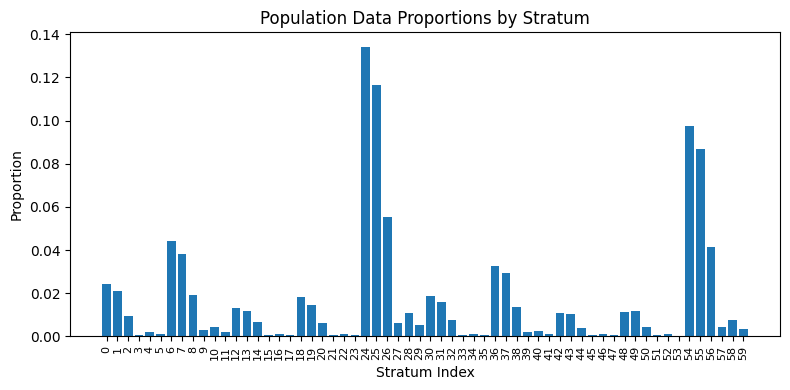

,Proportion
0,0.024
1,0.021
2,0.010
3,0.001
4,0.002


In [49]:
# Calculate the proportions in the population data
population_proportions = sample_selection_data.groupby(['Gender_m', 'Race_m', 'Age_Group_2'], observed=True).size().reset_index(name='Count')
population_proportions['Proportion'] = population_proportions['Count'] / population_proportions['Count'].sum()

# View the distribution of the population data in a chart
plt.figure(figsize=(8, 4))  # For the presentaion slide, the figure size is adjusted
plt.bar(range(len(population_proportions)), population_proportions['Proportion'])
# Reduce the tick label size for better readability
plt.xticks(rotation=45, fontsize=8)

plt.title('Population Data Proportions by Stratum')
plt.xlabel('Stratum Index')
plt.ylabel('Proportion')
plt.xticks(range(len(population_proportions)), population_proportions.index, rotation=90)
plt.tight_layout()
plt.show()

# Display the population proportions DataFrame
population_proportions[['Proportion']].head(5).round(3)

Notice that it will not be exactly the same proportions because of the small sample sizes in some strata, but they should be very close. If there are significant differences, it may indicate issues in the sampling process that need to be addressed.

# Weight calculation during post-stratification

Survey weights can also be calculated by different methods. This part of the demonstration shows the most common way to calculate weights using the original proportion from sampling and the proportion obtained from the respondents data.

### Import the respondents data file

In [50]:
# The respondents data file is a synthetic respondents data based on a survey. You can see that the collected responses are much lower than the sample size drawn.

# Data Folder should be defined already
#data_folder = './Data Files/'

# Import the respondents data file (synthetic respondents data based on a survey)
respondents_data = pd.read_excel(data_folder + 'respondents_file.xlsx')
# Make the output view smaller for presentation
print("Respondents dataset (first 3 rows):")
respondents_data[:3]

Respondents dataset (first 3 rows):


,Q1_Gender,Q2_Race,Q3_AgeGroup,Q4_Traffic_Accidents,Q5_Academic_Performance
0,Male,White,17-18,4.0,4.0
1,Female,White,17-18,3.0,3.0
2,Female,White,17-18,5.0,5.0


In [51]:
# Print the size of the respondents dataset
print(f"Size of the respondents dataset: {len(respondents_data)}")

Size of the respondents dataset: 241


We noticed there are some differences between the samples demographic proportions and the respondents demographic proportions. To adjust for these differences during the analysis phase, we can calculate weights for each demographic category based on the ratio of the respondent proportions to the sampled data proportions. These weights can then be applied during the analysis to ensure that the results accurately reflect the population demographics.

## Establish the variable weight and the overall weight

There are several steps in this process. First, we need to calculate the proportions of each stratum in both the sample dataset and the respondents dataset. Then, we can calculate the weights for each stratum by dividing the sample proportion by the respondent proportion. Finally, we can apply these weights to the respondents dataset to adjust for any discrepancies in representation.

In [52]:
# Recall the propotions from the sampled dataset and create a dictionary by the propotion and round to three decimal places
sampled_data_proportions = {
    "gender_sampled": sampled_dataset['Gender_m'].value_counts(normalize=True).round(3).to_dict(),
    "race_sampled": sampled_dataset['Race_m'].value_counts(normalize=True).round(3).to_dict(),
    "age_group_sampled": sampled_dataset['Age_Group_2'].value_counts(normalize=True).round(3).to_dict()
}

# Calculate the respondents demographic proportions of the three variables: Gender, Race, and Age Group and create a dictionary by the propotion and round to three decimal places
respondent_proportions = {
    "Gender_r": respondents_data['Q1_Gender'].value_counts(normalize=True).round(3).to_dict(),
    "Race_r": respondents_data['Q2_Race'].value_counts(normalize=True).round(3).to_dict(),
    "Age_Group_r": respondents_data['Q3_AgeGroup'].value_counts(normalize=True).round(3).to_dict()
}

In [53]:
# Define the two dictionaries for population and respondents proportions
popl_dict = sampled_data_proportions
resp_dict = respondent_proportions

Using each of the levels in the variables, then the population or respondent proportions can be retrieved from the dictionaries.
Here is a quick example:

In [54]:
# If Q1_Gender is 'Female', then the population proportion of 0.574 will be retrieved. 
popl_dict['gender_sampled']['Female']

0.574

In [55]:
# Then, the respondent proportion, 'Gender_r' of 0.631 will be retrieved for the denominator.
resp_dict['Gender_r']['Female']

0.631

Each weight is determined by dividing the sample proportion by the respondent proportion of each variable. Then, multiply the variable weights together to get the overall weight for each respondent.

In [56]:
# Weight for Gender is 'Female'
weight_female = popl_dict['gender_sampled']['Female'] / resp_dict['Gender_r']['Female']
# view the result and round to three decimal places
round(weight_female, 3)

0.91

## Calculate Weights in Respondents Data

### Create the weight calculation function based on the two propotions from sampled data and respondents data

This function calculates weights for each demographic category based on the ratio of the respondent proportions to the sampled data proportions. The procedures are as follows:

1. Accessing a dictionary inside another dictionary. For example, 'Gender_r' is a key in resp_dict, and its value was determined earlier from the respondent proportions calculation.

2. Looking up a value. Then you see the use of get() method to look up the value corresponding to the key row['Q1_Gender'] from the respondents survey result dataframe. 
This step will use the recorded value in the survey results dataframe to find the corresponding proportion in both the population and respondents dictionaries.

3. Lastly, the weight for each demographic category is calculated by dividing the population proportion by the respondent proportion. The total weight for each respondent is then obtained by multiplying the individual weights together.

In [57]:
# Function to calculate the weight for each respondent based on the three demographic variables
def calculate_weight(row, popl_dict, resp_dict):
    gender_weight = popl_dict['gender_sampled'].get(row['Q1_Gender'], 0) / resp_dict['Gender_r'].get(row['Q1_Gender'], 1)
    race_weight = popl_dict['race_sampled'].get(row['Q2_Race'], 0) / resp_dict['Race_r'].get(row['Q2_Race'], 1)
    age_group_weight = popl_dict['age_group_sampled'].get(row['Q3_AgeGroup'], 0) / resp_dict['Age_Group_r'].get(row['Q3_AgeGroup'], 1)
    total_weight = gender_weight * race_weight * age_group_weight
    return total_weight

### Apply this function to calculate weights for each respondent in the respondents dataframe

In [58]:
# Apply the weight calculation to each row in the respondents_data DataFrame
respondents_data['O_Weight'] = respondents_data.apply(calculate_weight, axis=1, args=(popl_dict, resp_dict))

# View the first three rows with the calculated weights
print("Respondents data with calculated weights (first 3 rows, rounded to 3 decimal places):")  
respondents_data[['Q1_Gender', 'Q2_Race', 'Q3_AgeGroup', 'O_Weight']].head(3).round(3)

Respondents data with calculated weights (first 3 rows, rounded to 3 decimal places):


,Q1_Gender,Q2_Race,Q3_AgeGroup,O_Weight
0,Male,White,17-18,1.830
1,Female,White,17-18,1.442
2,Female,White,17-18,1.442


In [59]:
# Apply the weight calculation to each row in the respondents_data DataFrame
respondents_data['Q4_with_weights'] = respondents_data['Q4_Traffic_Accidents'] * respondents_data['O_Weight']

# View the first three rows with the calculated weighted scores
print("Respondents data with weighted Q4_Traffic_Accidents scores (first 3 rows, rounded to 3 decimal places):")  
respondents_data[['Q4_Traffic_Accidents', 'O_Weight', 'Q4_with_weights']].head(3).round(3)

Respondents data with weighted Q4_Traffic_Accidents scores (first 3 rows, rounded to 3 decimal places):


,Q4_Traffic_Accidents,O_Weight,Q4_with_weights
0,4.0,1.830,7.320
1,3.0,1.442,4.326
2,5.0,1.442,7.210


In [60]:
traffic_accident_response = respondents_data[['Q4_Traffic_Accidents', 'Q4_with_weights']].copy()
non_weighted_mean = traffic_accident_response['Q4_Traffic_Accidents'].mean()
weighted_mean = traffic_accident_response['Q4_with_weights'].mean()

print(f"Non-weighted mean of Q4_Traffic_Accidents: {non_weighted_mean:.3f}")
print(f"Weighted mean of Q4_Traffic_Accidents: {weighted_mean:.3f}")

Non-weighted mean of Q4_Traffic_Accidents: 4.606
Weighted mean of Q4_Traffic_Accidents: 4.940


## Compare Distribution of Non-weighted Scores and Weighted Scores

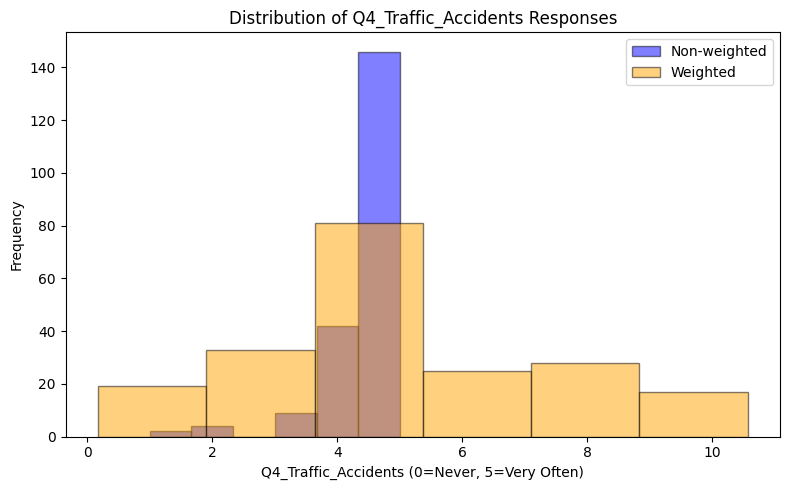

In [61]:
# Visual comparison of non-weighted vs weighted means with histogram

plt.figure(figsize=(8, 5))
plt.clf()  # Clear any previous plots

# Histogram of non-weighted responses
n, bins, patches = plt.hist(
    respondents_data['Q4_Traffic_Accidents'],
    bins=6,
    alpha=0.5,
    label='Non-weighted',
    color='blue',
    edgecolor='black'
)

# Histogram of weighted responses
n_w, bins_w, patches_w = plt.hist(
    respondents_data['Q4_with_weights'],
    bins=6,
    alpha=0.5,
    label='Weighted',
    color='orange',
    edgecolor='black'
)

plt.xlabel('Q4_Traffic_Accidents (0=Never, 5=Very Often)')
plt.ylabel('Frequency')
plt.title('Distribution of Q4_Traffic_Accidents Responses')
plt.legend()
plt.tight_layout()
plt.show()

The application of weights scaled the scores to better reflect the population structure. This is especially important when certain demographic groups are underrepresented or overrepresented in the respondents data compared to the overall population. By applying weights, we can adjust for these discrepancies and ensure that the analysis accurately reflects the population demographics.

In [62]:
# Distribution of the Q4_Traffic_Accidents variable before and after weighting
print("Summary statistics for Q4_Traffic_Accidents before and after weighting:")
respondents_data[['Q4_Traffic_Accidents', 'Q4_with_weights']].describe().round(3)

Summary statistics for Q4_Traffic_Accidents before and after weighting:


,Q4_Traffic_Accidents,Q4_with_weights
count,203.000,203.000
mean,4.606,4.940
std,0.753,2.345
min,1.000,0.174
25%,4.000,3.635
50%,5.000,4.723
75%,5.000,6.022
max,5.000,10.561


--- END ---